In [1]:
# Inputs 
stock_file_path = 'amzn_historical_quotes.xlsx'
index_file_path = 'spy_historical_quotes.xlsx'

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas import DataFrame, Series

In [3]:
# Constants
DATE_COL = 'Date'
RETURNS_NAME = 'Total Returns'
INDEX_SUFFIX = ' Index'
STOCK_SUFFIX = ' Stock'
INDEX_RETURNS_NAME = RETURNS_NAME + INDEX_SUFFIX
STOCK_RETURNS_NAME = RETURNS_NAME + STOCK_SUFFIX

In [4]:
# Functions
def get_returns(file_path):
    data_frame = pd.read_excel(file_path, index_col=DATE_COL, parse_dates=[DATE_COL])
    returns = data_frame['Change %'].astype('float')
    returns.dropna(inplace=True)
    returns.name = RETURNS_NAME
    return returns

def get_cumulative_returns(returns):
    return (((returns / 100) + 1).cumprod() - 1) * 100

def get_returns_extrema(returns, n):
    sorted = returns.sort_values()
    top = sorted.head(n=n)
    bottom = sorted.tail(n=n)
    extrema = pd.concat([top, bottom])
    extrema.index = extrema.index.strftime('%Y-%m-%d')
    return extrema

In [5]:
# ETL
stock_returns = get_returns(stock_file_path)
index_returns = get_returns(index_file_path)
returns = pd.merge(index_returns, stock_returns,on=DATE_COL, suffixes=(INDEX_SUFFIX, STOCK_SUFFIX))

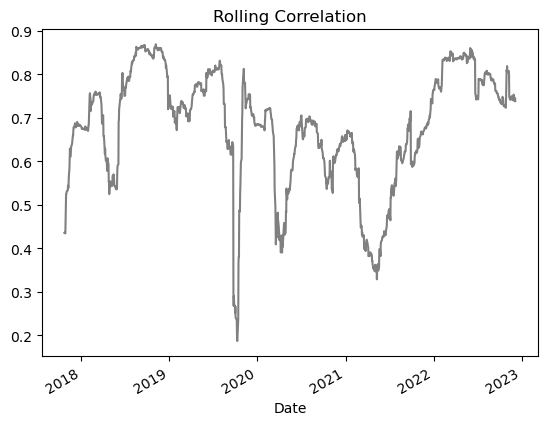

In [6]:
# Rolling Correlation
rolling_corrs = returns[STOCK_RETURNS_NAME].rolling(window=90, min_periods=90).corr(returns[INDEX_RETURNS_NAME]).dropna()
rolling_corrs_ax = rolling_corrs.plot(title='Rolling Correlation', color='grey')
rolling_corrs_ax.figure.savefig('rolling_corrs.png',bbox_inches='tight')

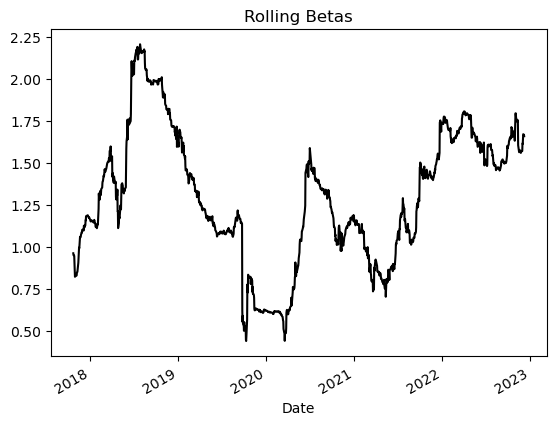

In [7]:
# Rolling Betas
rolling_cov = returns[STOCK_RETURNS_NAME].rolling(window=90, min_periods=90).cov(returns[INDEX_RETURNS_NAME]).dropna()
rolling_index_var = returns[INDEX_RETURNS_NAME].rolling(window=90, min_periods=90).var().dropna()
rolling_betas = rolling_cov / rolling_index_var
rolling_betas_ax = rolling_betas.plot(title='Rolling Betas',color='black')
rolling_betas_ax.figure.savefig('rolling_betas.png',bbox_inches='tight')

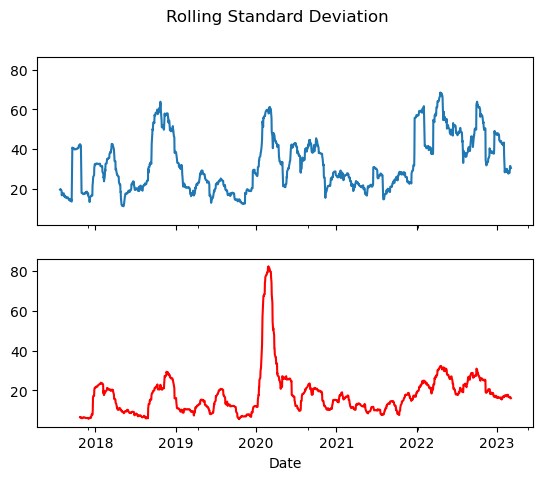

In [8]:
# Rolling Standard Deviation
annualize_std_factor = 252**.5
stock_rolling_stds = stock_returns.rolling(window=30, min_periods=30).std().dropna() * annualize_std_factor
index_rolling_stds = index_returns.rolling(window=30, min_periods=30).std().dropna() * annualize_std_factor
rolling_stds_fig, rolling_stds_axes = plt.subplots(nrows=2,sharex=True,sharey=True)
stock_rolling_stds.plot(ax=rolling_stds_axes[0],legend=False,subplots=True,title='Rolling Standard Deviation')
index_rolling_stds.plot(ax=rolling_stds_axes[1],legend=False,subplots=True,color='red')
rolling_stds_fig.savefig('rolling_stds.png',bbox_inches='tight')

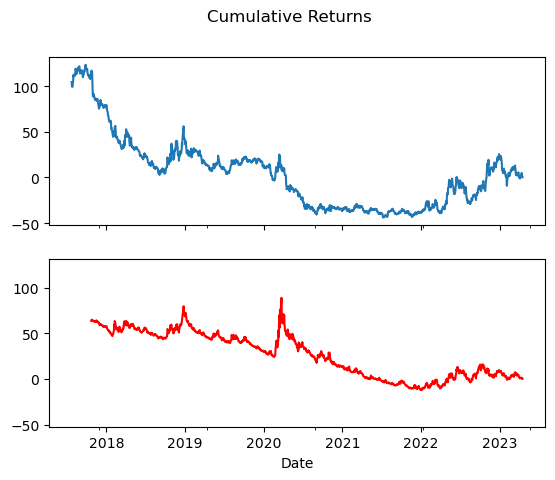

In [9]:
# Cumulative Returns
stock_cumulative_returns = get_cumulative_returns(stock_returns)
index_cumulative_returns = get_cumulative_returns(index_returns)
cumulative_returns_fig, cumulative_returns_axes = plt.subplots(nrows=2,sharex=True,sharey=True)
stock_cumulative_returns.plot(ax=cumulative_returns_axes[0],legend=False,subplots=True,title='Cumulative Returns')
index_cumulative_returns.plot(ax=cumulative_returns_axes[1],legend=False,subplots=True,color='red')
cumulative_returns_fig.savefig('cumulative_returns.png',bbox_inches='tight')

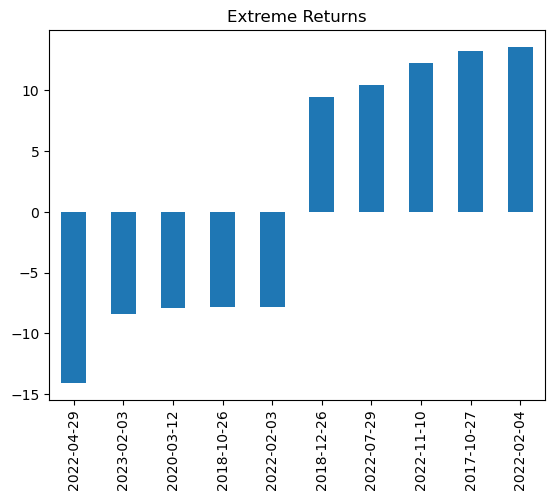

In [10]:
# Stock Extrema
count_returns_extrema = 5
stock_returns_extrema = get_returns_extrema(stock_returns,n=count_returns_extrema)
stock_returns_extrema_ax = stock_returns_extrema.plot(kind='bar', xlabel='', title='Extreme Returns')
stock_returns_extrema_ax.figure.savefig('stock_returns_extrema.png',bbox_inches='tight')